In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pwd = !pwd

In [2]:
matches = pd.read_csv(pwd[0][:-8]+'/stats/matchdata.csv')
events = pd.read_csv(pwd[0][:-8]+'/stats/events.csv')
ts = pd.read_csv(pwd[0][:-8]+'/stats/timeseries.csv')
wrestlers = pd.read_csv(pwd[0][:-8]+'/stats/wrestlers.csv')
wrestlers.head()

,name,rating,team_id,ew
0,Robert Rehm,968,USA,0.90
1,Paul Glynn,984,USA,2.60
2,Blaize Cabell,959,USA,1.75
3,Ben Whitford,1038,USA,6.30
4,Johnni DiJulius,993,USA,5.25


In [3]:
# calculates effective wins and assigns row-wise
for person in matches.focus_id.unique():
    group = matches[matches['focus_id']==person]
    ew = group.num_result.mean() * len(group.index)
    for i, row in wrestlers.iterrows():
        if row['name'] == person:
            wrestlers.at[i, 'ew'] = round(ew, 2)

In [4]:
wrestlers.sort_values('ew', ascending=False).head()

,name,rating,team_id,ew
332,Jason Nolf,1130,USA,15.45
312,Nathan Jackson,1108,USA,14.75
109,Tyler Graff,1160,USA,14.65
98,Garrett Ryan,1105,USA,14.50
213,Jaydin Eierman,1105,USA,14.05


# Start here

In [5]:
# sample for a singluar athlete report page
print('Be sure to follow spelling as seen on the official site.')
athlete = input('Enter wrestler: ')
fm = matches[matches.focus_id==athlete]

Be sure to follow spelling as seen on the official site.
Enter wrestler: Zain Retherford


In [6]:
def find_result_types(row):
    if row == 'WinF':
        return 'Fall'
    elif row == 'WinTF':
        return 'Tech'
    elif row == 'WinD':
        return 'Decision'
    elif row == 'LossD':
        return 'Decision'
    elif row == 'LossTF':
        return 'Tech'
    elif row == 'LossF':
        return 'Fall'



fm.loc[:,['binary_result']] = [1 if row > 1 else 0 for row in fm.num_result.values]
fm.loc[:,['binary_result_text']] = ['Win' if row > 1 else 'Loss' for row in fm.num_result.values]
fm.loc[:,['result_type']] = [find_result_types(row) for row in fm.result.values]
fm = fm[fm.duration != 0]


/home/nanthony007/VeritasAnalytics-Website/venv/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
HIC = fm.hia.sum()
HOC = fm.hoa.sum()
DC = fm.da.sum()
LSC = fm.lsa.sum()
GBC = fm.gba.sum()
TC = fm.ta.sum()
totalTDA = fm.hia.sum() + fm.hoa.sum() + fm.da.sum() + fm.lsa.sum() + fm.gba.sum() + fm.ta.sum() 

oHIC = fm.opp_hia.sum()
oHOC = fm.opp_hoa.sum()
oDC = fm.opp_da.sum()
oLSC = fm.opp_lsa.sum()
oGBC = fm.opp_gba.sum()
oTC = fm.opp_ta.sum()
ototalTDA = fm.opp_hia.sum() + fm.opp_hoa.sum() + fm.opp_da.sum() + fm.opp_lsa.sum() + fm.opp_gba.sum() + fm.opp_ta.sum() 


In [9]:
shot_labels = ['Head Inside', 'Head Outside', 'Double', 'LowShot', 'Counter', 'Throw', 
               'Head Inside', 'Head Outside', 'Double', 'LowShot', 'Counter', 'Throw']
athlete = ['Focus', 'Focus', 'Focus', 'Focus', 'Focus', 'Focus',
          'Opponent', 'Opponent', 'Opponent', 'Opponent', 'Opponent', 'Opponent']

rates = [fm.hi_rate.mean(), fm.ho_rate.mean(), fm.d_rate.mean(), fm.ls_rate.mean(), fm.gb_rate.mean(), fm.t_rate.mean(),
         fm.opp_hi_rate.mean(), fm.opp_ho_rate.mean(), fm.opp_d_rate.mean(), fm.opp_ls_rate.mean(), fm.gb_rate.mean(), fm.opp_t_rate.mean()]

prefs = [(HIC/totalTDA) * 100, (HOC/totalTDA) * 100, (DC/totalTDA) * 100, (LSC/totalTDA) * 100, (GBC/totalTDA) * 100, (TC/totalTDA) * 100,
        (oHIC/ototalTDA) * 100, (oHOC/ototalTDA) * 100, (oDC/ototalTDA) * 100, (oLSC/ototalTDA) * 100, (oGBC/ototalTDA) * 100, (oTC/ototalTDA) * 100]

rate_df = pd.DataFrame()
rate_df['wrestler'] = athlete
rate_df['shottype'] = shot_labels
rate_df['rate'] = rates
rate_df['pref'] = prefs
fm2 = pd.melt(fm, id_vars=['binary_result'], value_vars=['npf'])

In [10]:
fm_inter = fm.select_dtypes(exclude=['object'])
fm_inter = fm_inter.drop(columns=['mov', 'focus_score', 'opp_score', 'num_result'])

corrs = fm_inter.corr()['binary_result'][:-1].dropna()
corrs = corrs[corrs > -1]
corrs = corrs[corrs < 1]
bad = corrs.sort_values(ascending=True)[:10]
good = corrs.sort_values(ascending=False)[:10]

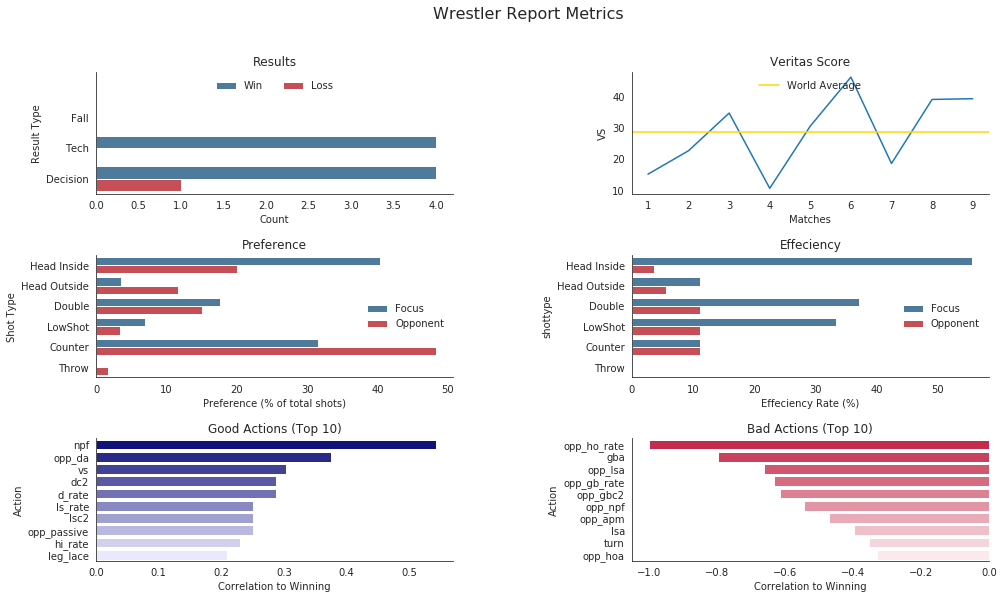

In [11]:
sns.set_style('white', {'axes.spines.right':False, 'axes.spines.top':False})

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(16,9))
plt.subplots_adjust(wspace = 0.50, hspace = 0.50)

g1 = sns.countplot(y='result_type', hue='binary_result_text', data=fm, order=['', 'Fall', 'Tech', 'Decision'],
            palette=sns.diverging_palette(240, 10, n=2), ax=ax1)
ax1.set_title('Results')
ax1.set_xlabel("Count")
ax1.set_ylabel("Result Type")
ax1.legend(loc='upper center', ncol=2, frameon=False)

g2 = sns.lineplot(data=fm, x=range(1, len(fm.index)+1), y='vs', ax=ax2)
ax2.axhline(fm.vs.mean(), label='World Average', color='gold')
ax2.set_title("Veritas Score")
ax2.set_xlabel("Matches")
ax2.set_ylabel("VS")
ax2.legend(loc='upper center', frameon=False)
ax2.legend_.set_title("")

g3 = sns.barplot(x='pref', y='shottype', hue='wrestler', data=rate_df,  
            palette=sns.diverging_palette(240, 10, n=2), ax=ax3)
ax3.set_title('Preference')
ax3.set_xlabel("Preference (% of total shots)")
ax3.set_ylabel("Shot Type")
ax3.legend(loc='center right', frameon=False)
ax3.legend_.set_title("")

g4 = sns.barplot(x='rate', y='shottype', hue='wrestler', data=rate_df,
            palette=sns.diverging_palette(240, 10, n=2), ax=ax4)
ax4.set_title('Effeciency')
ax4.set_xlabel("Effeciency Rate (%)")
ax4.legend(loc="center right", frameon=False)
ax4.legend_.set_title("")

g5 = sns.barplot(x=good.values, y=good.index, palette=sns.light_palette("darkblue", 10, reverse=True), ax=ax5)
ax5.set_title('Good Actions (Top 10)')
ax5.set_xlabel("Correlation to Winning")
ax5.set_ylabel("Action")

g6 = sns.barplot(x=bad.values, y=bad.index, palette=sns.light_palette("crimson", 10, reverse=True), ax=ax6)
ax6.set_title('Bad Actions (Top 10)')
ax6.set_xlabel("Correlation to Winning")
ax6.set_ylabel("Action")

plt.suptitle('Wrestler Report Metrics',size=16)
plt.savefig('reports.png', dpi=400)
plt.show()


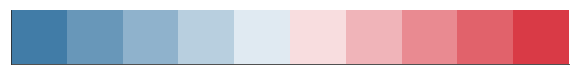

In [599]:
sns.palplot(sns.diverging_palette(240, 10, n=10, center='light'))